In [143]:
#!pip install gensim

In [144]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.manifold import TSNE

import pickle
import itertools

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

from typing import List, Dict, Tuple, Set

from keras.layers.preprocessing.text_vectorization import TextVectorization

import warnings
warnings.filterwarnings('ignore')

In [145]:
print('Indexing word vectors.')

embeddings_index = {}
f = open('../../PreProcessedData/Requirement/glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 400000 word vectors.


In [146]:
pickle.dump({'embeddings_index' : embeddings_index } , open('../../PreProcessedData/Requirement/save.glove.6B.100d.txt', 'wb'))

In [147]:
MAX_TOKENS = 100
MAX_TITLE_LENGTH = 21
MAX_DESCRIPTION_LENGTH = 350
EMBEDDING_DIM = 100

In [148]:
def build_vocab(sentences: List[str], sequence_length: int):
    vectorizer = TextVectorization(max_tokens=MAX_TOKENS - 2,output_sequence_length=sequence_length)
    vectorizer.adapt(sentences)
    vocab = vectorizer.get_vocabulary()
    word_index = dict(zip(vocab, range(len(vocab))))

    return vectorizer, word_index

In [149]:
def create_embedding_matrix(embeddings_index: Dict[str, np.ndarray],word_index: Dict[str, int],verbose=False):
    hits = 0
    misses = 0

    #To initialize Embedding Matrix
    embedding_matrix = np.zeros((MAX_TOKENS, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
        # Words not found in Embedding Index will zeros.
        # This includes the representation for "Padding" and "OOV"
            embedding_matrix[i] = embedding_vector
            hits += 1
        else:
            misses += 1

    if verbose:
        print('Embedding shape:', embedding_matrix.shape)
        print(f'Found {hits} words, missed {misses}.')

    return embedding_matrix

In [150]:
#Preprocessing Dataset
def preprocessing_data(df_original, similarity, sample_n):
    df_original = df_original.sample(n=sample_n, random_state=1).reset_index(drop=True)
    
    df = pd.DataFrame()

    df['Unnamed: 0'] = df_original['Unnamed: 0']
    df['description1'] = df_original['Description1']
    df['description2'] = df_original['Description2']
    df['is_similar'] = df_original['is_similar']

    df['description1'] = df['description1'].str.replace('[','').str.replace(']','')
    df['description2'] = df['description2'].str.replace('[','').str.replace(']','')

    df['description1'] = df['description1'].str.replace("'", "")
    df['description2'] = df['description2'].str.replace("'", "")

    df.loc[df['is_similar'] == 1, 'Textual_Similarity'] = similarity
    
    #To show Data
    display(df.head())
    
    return df

# Eclipse Visualization
#### Textually Similar

In [151]:
df_sim_eclipse_og = pd.read_csv('../../PreProcessedData/Eclipse/Eclipse_textually_similar_pair.csv')
df_sim_eclipse =  preprocessing_data(df_sim_eclipse_og, 'Textually Similar', 100)

descr_vectorizer, descr_word_index = build_vocab([df_sim_eclipse.description1, df_sim_eclipse.description2],MAX_DESCRIPTION_LENGTH)

#To Create Embedding Matrix of Description
descr_embedding_matrix = create_embedding_matrix(embeddings_index, descr_word_index, True)

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,391,since the upgrade to the keyboard shortcut...,after recent upgrade from integration buil...,1,Textually Similar
1,459,package public record package ...,using build id create a record public r...,1,Textually Similar
2,490,i used to have an ubuntu vm but i discove...,created attachment error log hi using ...,1,Textually Similar
3,39,what steps will reproduce the problem win...,created attachment screenshot of menu bar n...,1,Textually Similar
4,302,the following problem was reported via the aut...,using oxygen build id entry org eclip...,1,Textually Similar


Embedding shape: (100, 100)
Found 82 words, missed 16.


In [152]:
#Picking top 100 points as TSNE takes a lot of time for 15K points
top_100_sim_eclipse = descr_embedding_matrix

model_sim_eclipse = TSNE(n_components=2, random_state=0, perplexity = 40, n_iter=7000, metric='cosine')

#Configuring the Parameters
tsne_data_sim_eclipse = model_sim_eclipse.fit_transform(top_100_sim_eclipse)

sim_label_eclipse = df_sim_eclipse["Textual_Similarity"]
tsne_data_sim_eclipse = np.vstack((tsne_data_sim_eclipse.T, sim_label_eclipse)).T
tsne_df_sim_eclipse = pd.DataFrame(data=tsne_data_sim_eclipse, columns=("Dim_1", "Dim_2","Textual_Similarity"))

#### Textually Dissimilar 

In [153]:
df_dissim_eclipse_og = pd.read_csv('../../PreProcessedData/Eclipse/Eclipse_textually_dissimilar_pair.csv')
df_dissim_eclipse =  preprocessing_data(df_dissim_eclipse_og, 'Textually Dissimilar', 100)

descr_vectorizer, descr_word_index = build_vocab([df_dissim_eclipse.description1, df_dissim_eclipse.description2],MAX_DESCRIPTION_LENGTH)

#To create Embedding Matrix of Description
descr_embedding_matrix = create_embedding_matrix(embeddings_index, descr_word_index, True)

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,345,when rebuilding the bindings manually i see t...,now that the epl has been fully rolled out...,1,Textually Dissimilar
1,190,can not access our hipp tried to restart ...,hi cannot open,1,Textually Dissimilar
2,685,i have the following code final boolean ann...,the current null analysis in ecj does not reco...,1,Textually Dissimilar
3,191,hello the kura hipp is unavailable i ve trie...,hi cannot open,1,Textually Dissimilar
4,644,all the builds kicked off from are waiting...,e g lib job master console umbrella jo...,1,Textually Dissimilar


Embedding shape: (100, 100)
Found 94 words, missed 4.


In [154]:
#Picking top 100 points as TSNE takes a lot of time for 15K points
top_100_dissim_eclipse = descr_embedding_matrix

model_dissim_eclipse = TSNE(n_components=2, random_state=0, perplexity = 40, n_iter=7000, metric='cosine')

#Configuring the Parameters
tsne_data_dissim_eclipse = model_dissim_eclipse.fit_transform(top_100_dissim_eclipse)

dissim_label_eclipse = df_dissim_eclipse["Textual_Similarity"]
tsne_data_dissim_eclipse = np.vstack((tsne_data_dissim_eclipse.T, dissim_label_eclipse)).T
tsne_df_dissim_eclipse = pd.DataFrame(data=tsne_data_dissim_eclipse, columns=("Dim_1", "Dim_2","Textual_Similarity"))

In [155]:
#To Concatenate Textually Similar & Dissimilar Data
complete_tsne_df_eclipse = pd.concat([tsne_df_sim_eclipse, tsne_df_dissim_eclipse], ignore_index=True)

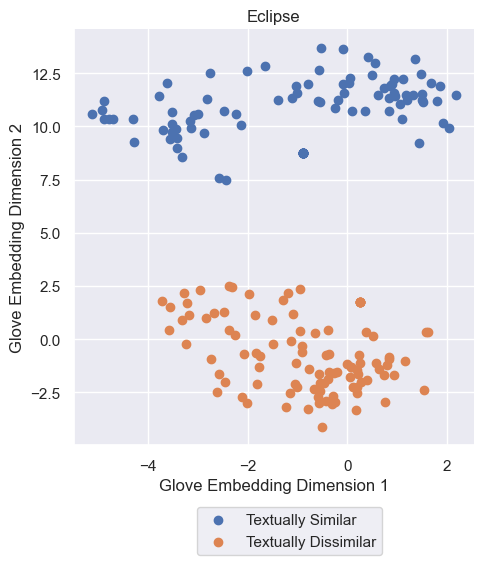

In [156]:
sns.set(font_scale = 2.0)
sns.set(rc={'figure.figsize':(1,1)})
sns.FacetGrid(complete_tsne_df_eclipse, hue="Textual_Similarity", height=5).map(plt.scatter, 'Dim_1', 'Dim_2')
plt.legend(labels=['Textually Similar', 'Textually Dissimilar'],bbox_to_anchor=(0.79, -0.13))
plt.xlabel('Glove Embedding Dimension 1')
plt.ylabel('Glove Embedding Dimension 2')
plt.title('Eclipse')
plt.show()

# Firefox Visualization
#### Textually Similar

In [157]:
df_sim_firefox_og = pd.read_csv('../../PreProcessedData/Firefox/Firefox_textually_similar_pair.csv')
df_sim_firefox =  preprocessing_data(df_sim_firefox_og, 'Textually Similar', 100)

descr_vectorizer, descr_word_index = build_vocab([df_sim_firefox.description1, df_sim_firefox.description2],MAX_DESCRIPTION_LENGTH)

#To Create Embedding Matrix of Description
descr_embedding_matrix = create_embedding_matrix(embeddings_index, descr_word_index, True)

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,858,created attachment firefox bing icon png us...,bing released a new logo and renamed bing to m...,1,Textually Similar
1,989,user agent mozilla gecko firefox ...,saw this feedback i ve now found that...,1,Textually Similar
2,636,created attachment rec of the issue gif af...,i think i have a fix incoming but basically ...,1,Textually Similar
3,734,user agent mozilla gecko firefox ...,reproducible always steps to reproduce o...,1,Textually Similar
4,724,user agent mozilla gecko firefox ...,user agent mozilla gecko firefox ...,1,Textually Similar


Embedding shape: (100, 100)
Found 96 words, missed 2.


In [158]:
#Picking top 100 points as TSNE takes a lot of time for 15K points
top_100_sim_firefox = descr_embedding_matrix

model_sim_firefox = TSNE(n_components=2, random_state=2, perplexity = 40, n_iter=7000, metric='cosine')

#Configuring the Parameters
tsne_data_sim_firefox = model_sim_firefox.fit_transform(top_100_sim_firefox)

sim_label_firefox = df_sim_firefox["Textual_Similarity"]
tsne_data_sim_firefox = np.vstack((tsne_data_sim_firefox.T, sim_label_firefox)).T
tsne_df_sim_firefox = pd.DataFrame(data=tsne_data_sim_firefox, columns=("Dim_1", "Dim_2","Textual_Similarity"))

#### Textually Dissimilar 

In [159]:
df_dissim_firefox_og = pd.read_csv('../../PreProcessedData/Firefox/Firefox_textually_dissimilar_pair.csv')
df_dissim_firefox =  preprocessing_data(df_dissim_firefox_og, 'Textually Dissimilar', 100)

descr_vectorizer, descr_word_index = build_vocab([df_dissim_firefox.description1, df_dissim_firefox.description2],MAX_DESCRIPTION_LENGTH)

#To create Embedding Matrix of Description
descr_embedding_matrix = create_embedding_matrix(embeddings_index, descr_word_index, True)

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,120,filed by philringnalda at gmail com job...,filed by philringnalda at gmail com job...,1,Textually Dissimilar
1,1317,instant crash when you try to view source on a...,str open a new tab with command ctrl t ...,1,Textually Dissimilar
2,11,filed by cbook at mozilla com job id ...,created attachment notification logic png a...,1,Textually Dissimilar
3,437,created attachment screenshot from ...,clicking on the hamburger menu icon today does...,1,Textually Dissimilar
4,482,hook up the sidebar switcher to the synced tab...,it s a header in the sidebar that lets you swi...,1,Textually Dissimilar


Embedding shape: (100, 100)
Found 87 words, missed 11.


In [160]:
#Picking top 100 points as TSNE takes a lot of time for 15K points
top_100_dissim_firefox = descr_embedding_matrix

model_dissim_firefox = TSNE(n_components=2, random_state=2,perplexity = 40,n_iter=7000,metric='cosine')

#Configuring the Parameters
tsne_data_dissim_firefox = model_dissim_firefox.fit_transform(top_100_dissim_firefox)

dissim_label_firefox = df_dissim_firefox["Textual_Similarity"]
tsne_data_dissim_firefox = np.vstack((tsne_data_dissim_firefox.T, dissim_label_firefox)).T
tsne_df_dissim_firefox = pd.DataFrame(data=tsne_data_dissim_firefox, columns=("Dim_1", "Dim_2","Textual_Similarity"))

In [161]:
#To Concatenate Textually Similar & Dissimilar Data
complete_tsne_df_firefox = pd.concat([tsne_df_sim_firefox, tsne_df_dissim_firefox], ignore_index=True)

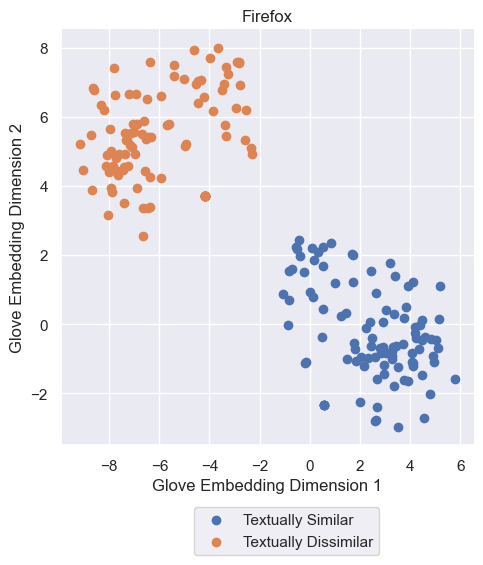

In [162]:
sns.set(font_scale = 2.0)
sns.set(rc={'figure.figsize':(1,1)})
sns.FacetGrid(complete_tsne_df_firefox, hue="Textual_Similarity", height=5).map(plt.scatter, 'Dim_1', 'Dim_2')
plt.legend(labels=['Textually Similar', 'Textually Dissimilar'],bbox_to_anchor=(0.79, -0.13))
plt.xlabel('Glove Embedding Dimension 1')
plt.ylabel('Glove Embedding Dimension 2')
plt.title('Firefox')
plt.show()

# Mobile Visualization
#### Textually Similar

In [163]:
df_sim_mobile_og = pd.read_csv('../../PreProcessedData/Mobile/Mobile_textually_similar_pair.csv')
df_sim_mobile_og = pd.concat([df_sim_mobile_og,df_sim_mobile_og,df_sim_mobile_og])
df_sim_mobile = preprocessing_data(df_sim_mobile_og, 'Textually Similar', 100)

descr_vectorizer, descr_word_index = build_vocab([df_sim_mobile.description1, df_sim_mobile.description2],MAX_DESCRIPTION_LENGTH)

#To Create Embedding Matrix of Description
descr_embedding_matrix = create_embedding_matrix(embeddings_index, descr_word_index, True)

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,25,filed by dvarga at mozilla com parsed...,filed by csabou at mozilla com parsed...,1,Textually Similar
1,116,this bug is for crash report bp ...,we re throwing invalid color format introdu...,1,Textually Similar
2,46,filed by ccoroiu at mozilla com parse...,filed by apavel at mozilla com parsed...,1,Textually Similar
3,29,filed by apavel at mozilla com job id ...,i get the following errors today home snorp...,1,Textually Similar
4,62,filed by abutkovits at mozilla com pa...,filed by csabou at mozilla com parsed...,1,Textually Similar


Embedding shape: (100, 100)
Found 80 words, missed 18.


In [164]:
#Picking top 100 points as TSNE takes a lot of time for 15K points
top_100_sim_mobile = descr_embedding_matrix

model_sim_mobile = TSNE(n_components=2, random_state=42 ,perplexity = 40, n_iter=7000, metric='cosine')

#Configuring the Parameters
tsne_data_sim_mobile = model_sim_mobile.fit_transform(top_100_sim_mobile)

sim_label_mobile = df_sim_mobile["Textual_Similarity"]
tsne_data_sim_mobile = np.vstack((tsne_data_sim_mobile.T, sim_label_mobile)).T
tsne_df_sim_mobile = pd.DataFrame(data=tsne_data_sim_mobile, columns=("Dim_1", "Dim_2","Textual_Similarity"))

#### Textually Dissimilar

In [165]:
df_dissim_mobile_og = pd.read_csv('../../PreProcessedData/Mobile/Mobile_textually_dissimilar_pair.csv')
df_dissim_mobile_og = pd.concat([df_dissim_mobile_og,df_dissim_mobile_og,df_dissim_mobile_og])
df_dissim_mobile =  preprocessing_data(df_dissim_mobile_og, 'Textually Dissimilar', 100)

descr_vectorizer, descr_word_index = build_vocab([df_dissim_mobile.description1, df_dissim_mobile.description2],MAX_DESCRIPTION_LENGTH)

#To create Embedding Matrix of Description
descr_embedding_matrix = create_embedding_matrix(embeddings_index, descr_word_index, True)

,Unnamed: 0,description1,description2,is_similar,Textual_Similarity
0,16,ios got an empty notification after a tab was ...,the very first notification i received was emp...,1,Textually Dissimilar
1,51,add a method to bvc to reify a tab from a sent...,implement the following two fxa messages api c...,1,Textually Dissimilar
2,34,this should be done on application foregroundi...,implement the following two fxa messages api c...,1,Textually Dissimilar
3,114,we ve had this for a long time should fix it ...,we ve had this for a while but i guess we sho...,1,Textually Dissimilar
4,76,when testing out the multi account containers...,this implements the cookiestoreid parameter ...,1,Textually Dissimilar


Embedding shape: (100, 100)
Found 85 words, missed 13.


In [166]:
#Picking top 100 points as TSNE takes a lot of time for 15K points
top_100_dissim_mobile = descr_embedding_matrix

model_dissim_mobile = TSNE(n_components=2, random_state=42, perplexity = 40, n_iter=7000, metric='cosine')

#Configuring the Parameters
tsne_data_dissim_mobile = model_dissim_mobile.fit_transform(top_100_dissim_mobile)

dissim_label_mobile = df_dissim_mobile["Textual_Similarity"]
tsne_data_dissim_mobile = np.vstack((tsne_data_dissim_mobile.T, dissim_label_mobile)).T
tsne_df_dissim_mobile = pd.DataFrame(data=tsne_data_dissim_mobile, columns=("Dim_1", "Dim_2","Textual_Similarity"))

In [167]:
#To Concatenate Textually Similar & Dissimilar Data
complete_tsne_df_mobile = pd.concat([tsne_df_sim_mobile, tsne_df_dissim_mobile], ignore_index=True)

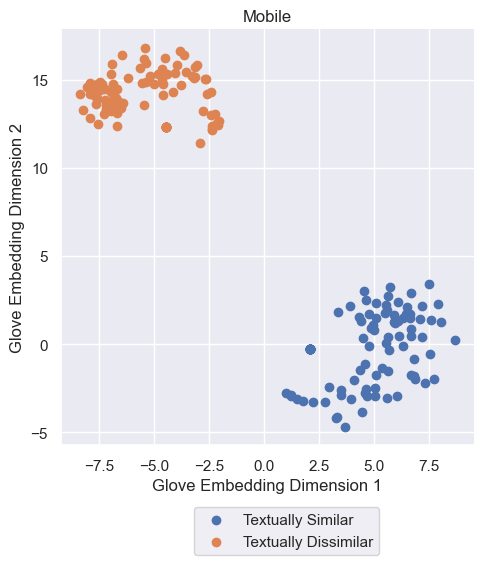

In [168]:
sns.set(font_scale = 2.0)
sns.set(rc={'figure.figsize':(1,1)})
sns.FacetGrid(complete_tsne_df_mobile, hue="Textual_Similarity", height=5).map(plt.scatter, 'Dim_1', 'Dim_2')
plt.legend(labels=['Textually Similar', 'Textually Dissimilar'],bbox_to_anchor=(0.79, -0.13))
plt.xlabel('Glove Embedding Dimension 1')
plt.ylabel('Glove Embedding Dimension 2')
plt.title('Mobile')
plt.show()